# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

import statsmodels.formula.api as smf
import statsmodels.api as sm

import warnings

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('previsao_de_renda.csv')
df.head()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [4]:
# removendo variáveis desnecessárias
df.drop(columns=['Unnamed: 0', 'data_ref', 'id_cliente'], axis=1, inplace=True)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [5]:
# Removendo os valores NA
df.dropna(inplace=True, axis=0, how='any', ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12427 entries, 0 to 12426
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   12427 non-null  object 
 1   posse_de_veiculo       12427 non-null  bool   
 2   posse_de_imovel        12427 non-null  bool   
 3   qtd_filhos             12427 non-null  int64  
 4   tipo_renda             12427 non-null  object 
 5   educacao               12427 non-null  object 
 6   estado_civil           12427 non-null  object 
 7   tipo_residencia        12427 non-null  object 
 8   idade                  12427 non-null  int64  
 9   tempo_emprego          12427 non-null  float64
 10  qt_pessoas_residencia  12427 non-null  float64
 11  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 995.3+ KB


In [6]:
# Criando variáveis dummines para as variáveis categóricas
df = df.astype({'posse_de_veiculo': object, 'posse_de_imovel': object, 'qtd_filhos': int, 'idade': int, 'qt_pessoas_residencia': int})
df = pd.get_dummies(data=df, drop_first=True, dtype='int')
df.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_M,posse_de_veiculo_True,posse_de_imovel_True,tipo_renda_Bolsista,tipo_renda_Empresário,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,26,6.602740,1,8060.34,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,0
1,0,28,7.183562,2,1852.15,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,35,0.838356,2,2253.89,0,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,30,4.846575,3,6600.77,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,33,4.293151,1,6475.97,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [7]:
# 1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).

X = df.drop('renda', axis=1)  # Variáveis preditoras
y = df['renda']  # Variável de resposta

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# 2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o R² na base de testes. Qual o melhor modelo?

alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
ridge_models = {}

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    ridge_models[alpha] = {'model': ridge, 'mse': mse, 'R²':  ridge.score(X_train, y_train)}

# Encontrar o melhor modelo de Ridge
best_ridge_alpha = min(ridge_models, key=lambda k: ridge_models[k]['mse'])
best_ridge_model = ridge_models[best_ridge_alpha]['model']
best_ridge_mse = ridge_models[best_ridge_alpha]['mse']
best_ridge_r2 = ridge_models[best_ridge_alpha]['R²']
print(f"Melhor modelo de Ridge com alpha {best_ridge_alpha}, MSE: {best_ridge_mse}, R²: {best_ridge_r2}")

Melhor modelo de Ridge com alpha 0.1, MSE: 39752754.591826305, R²: 0.2465256918758919


In [9]:
# 3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?

lasso_models = {}

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    lasso_models[alpha] = {'model': lasso, 'mse': mse, 'R²': lasso.score(X_train, y_train)}

# Encontrar o melhor modelo de LASSO
best_lasso_alpha = min(lasso_models, key=lambda k: lasso_models[k]['R²'])
best_lasso_model = lasso_models[best_lasso_alpha]['model']
best_lasso_mse = lasso_models[best_lasso_alpha]['mse']
best_lasso_R2 = lasso_models[best_lasso_alpha]['R²']
print(f"Melhor modelo de LASSO com alpha {best_lasso_alpha}, MSE: {best_lasso_mse}, R²: {best_lasso_R2}")

Melhor modelo de LASSO com alpha 0.1, MSE: 39750519.21707845, R²: 0.2465242353922258


In [10]:
# 4. Rode um modelo *stepwise*. Avalie o R² na base de testes. Qual o melhor resultado?

# Usando RFE (recursive feature elimination) com Linear Regression
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1, verbose=1)
selector = selector.fit(X_train, y_train)

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


In [11]:
selector.get_feature_names_out()

array(['tempo_emprego', 'sexo_M', 'posse_de_veiculo_True',
       'tipo_renda_Empresário', 'educacao_Superior completo'],
      dtype=object)

In [12]:
melhores_variaveis= ['tempo_emprego', 'sexo_M', 'posse_de_veiculo_True', 'tipo_renda_Empresário', 'educacao_Superior completo']
reg_melhores_variaveis = LinearRegression()
reg_melhores_variaveis.fit(X_train[melhores_variaveis], y_train)

LinearRegression()

In [13]:
y_pred_modelo = reg_melhores_variaveis.predict(X_test[melhores_variaveis])

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_modelo))
print("R²: %.2f" % r2_score(y_test, y_pred_modelo))

Mean squared error: 40022016.90
R²: 0.29


In [14]:
# 6. Partindo dos modelos que você ajustou, tente melhorar o R² na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

colunas = ['tempo_emprego', 'sexo_M', 'posse_de_veiculo_True', 'tipo_renda_Empresário', 'educacao_Superior completo', 'renda']
df_2 = df[colunas]
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12427 entries, 0 to 12426
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tempo_emprego               12427 non-null  float64
 1   sexo_M                      12427 non-null  int32  
 2   posse_de_veiculo_True       12427 non-null  int32  
 3   tipo_renda_Empresário       12427 non-null  int32  
 4   educacao_Superior completo  12427 non-null  int32  
 5   renda                       12427 non-null  float64
dtypes: float64(2), int32(4)
memory usage: 388.5 KB


In [15]:
df_2.describe()

,tempo_emprego,sexo_M,posse_de_veiculo_True,tipo_renda_Empresário,educacao_Superior completo,renda
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,7.722635,0.364207,0.423835,0.282289,0.377806,6116.539763
std,6.711189,0.481226,0.494185,0.450131,0.484858,8890.061601
min,0.117808,0.000000,0.000000,0.000000,0.000000,118.710000
25%,2.973973,0.000000,0.000000,0.000000,0.000000,2117.235000
50%,6.013699,0.000000,0.000000,0.000000,0.000000,3681.050000
75%,10.120548,1.000000,1.000000,1.000000,1.000000,6846.650000
max,42.906849,1.000000,1.000000,1.000000,1.000000,245141.670000


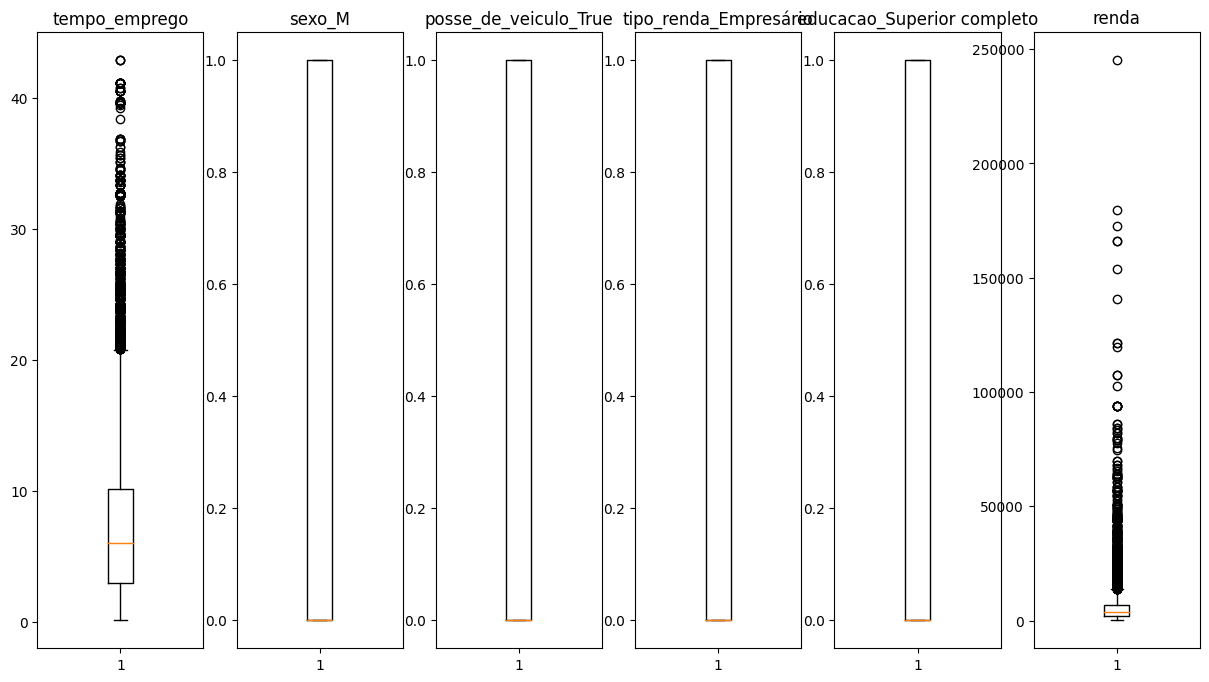

In [16]:
x = ['tempo_emprego', 'sexo_M', 'posse_de_veiculo_True', 'tipo_renda_Empresário', 'educacao_Superior completo', 'renda']
fig, axs = plt.subplots(1, 6, figsize=(15, 8))
for p in range(0,6):
    axs[p].boxplot(df_2[x[p]])
    axs[p].set_title(df_2.columns[p])

plt.show()
#boxplot = df_2.boxplot(column=['tempo_emprego', 'sexo_M', 'posse_de_veiculo_True', 'tipo_renda_Empresário', 'educacao_Superior completo'], ax=1)


In [17]:
# Com base no boxplot vamos fazer um corte nas variáveis tempo_emprego e renda
df_2 = df_2[df_2['tempo_emprego'] < 20]
df_2 = df_2[df_2['renda'] < 100000]

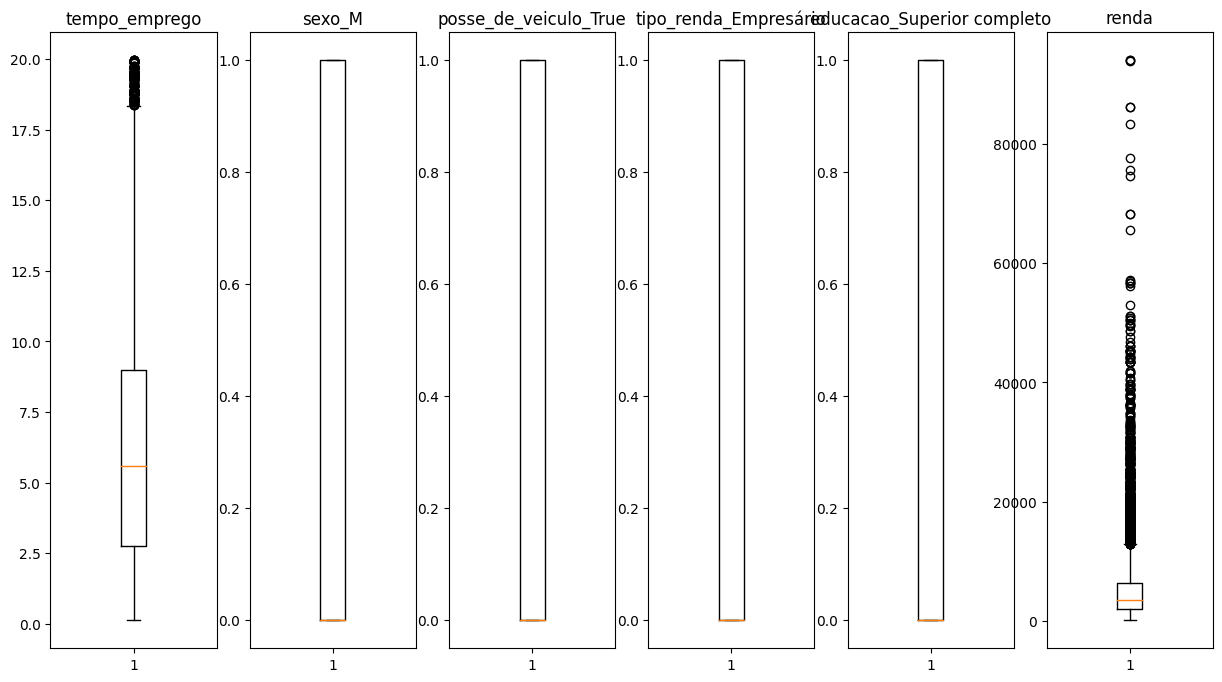

In [18]:
x = ['tempo_emprego', 'sexo_M', 'posse_de_veiculo_True', 'tipo_renda_Empresário', 'educacao_Superior completo', 'renda']
fig, axs = plt.subplots(1, 6, figsize=(15, 8))
for p in range(0,6):
    axs[p].boxplot(df_2[x[p]])
    axs[p].set_title(df_2.columns[p])

plt.show()

In [19]:
# Aplicando a tranformação log na renda
df_2['log_renda'] = np.log(df_2['renda'])
df_2.head()

,tempo_emprego,sexo_M,posse_de_veiculo_True,tipo_renda_Empresário,educacao_Superior completo,renda,log_renda
0,6.602740,0,0,1,0,8060.34,8.994711
1,7.183562,1,1,0,1,1852.15,7.524102
2,0.838356,0,1,1,1,2253.89,7.720413
3,4.846575,0,0,0,1,6600.77,8.794942
4,4.293151,1,1,0,0,6475.97,8.775854


In [20]:
df_2.shape

(11617, 7)

In [21]:
# Dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(df_2[['tempo_emprego', 'sexo_M', 'posse_de_veiculo_True', 'tipo_renda_Empresário', 'educacao_Superior completo']], 
                                                    df_2['log_renda'], 
                                                    test_size=0.2, 
                                                    random_state=2023)

# Modelo de regressão
reg_melhores_variaveis = LinearRegression()
reg_melhores_variaveis.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred_modelo = reg_melhores_variaveis.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_modelo))
print("R²: %.2f" % r2_score(y_test, y_pred_modelo))

Mean squared error: 0.49
R²: 0.31


- Eliminando alguns outliers e aplicando a tranformação log na variável renda, foi possível melhorar o modelo

In [23]:
# 7. Ajuste uma árvore de regressão e veja se consegue um R² melhor com ela.

# Ajuste da árvore de regressão
arvore_reg = DecisionTreeRegressor()
arvore_reg.fit(X_train, y_train)
y_pred_arvore = arvore_reg.predict(X_test)
arvore_mse = mean_squared_error(y_test, y_pred_arvore)
arvore_r2 = r2_score(y_test, y_pred_arvore)
print(f"Modelo de Árvore de Regressão, MSE: {arvore_mse}")
print(f"Modelo de Árvore de Regressão, R²: {arvore_r2}")

Modelo de Árvore de Regressão, MSE: 0.5074525607196296
Modelo de Árvore de Regressão, R²: 0.2877887429204077


- Não houve melhora no R² com a aplicação de uma árvore de regressão